# LangGraph practice#2 구성도 

![구성도](/home/ansgyqja/AI_application/images/2.practice.png)


### 기본 import

In [1]:
import os,sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('utils'), '..')))
from module.utils import * 
from module.prompt import * 
from module.custom_model import *


### lang smith 추적 

In [2]:
strt_langsmith('practive_2')

LangSmith 추적을 시작합니다.
[프로젝트명]
practive_2


### retriever 도구

In [3]:
loader = get_pdf_loader()
splitter = get_text_splitter()
docs = get_docs(loader,splitter)
embedding = get_embedding()
retrieve = get_retriever(docs,embedding)
# retriever_tool = get_retriever_tool(retrieve)

### State 설정

In [4]:
from typing import TypedDict, Annotated, List, Literal
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    question : Annotated[list,add_messages]      # 사용자 질의 
    answer : Annotated[str,"Answer"]             # 최종 답변
    is_relevant : Annotated[str,"yes or no"]     # 연관성 검사
    messages : Annotated[str,'tmp_message']      # retriver 된 내용 
    document : Annotated[list,'grade_document']  # 필터링된 doc 


### 기본 노드

In [5]:
def re_write_query(state : State) -> State :
    """ 
        question  을 새로 작성하여 question 에 저장하고 routing 재수행
    """
    print('**'*50)
    print('re_write_query')
    print('**'*50)
    query = state['question'][-1].content
    chain = get_prompt_re_write()|get_gemini()|StrOutputParser()
    re_query = chain.invoke({'question':query})
    return State({'question':re_query})

def web_search(state : State)->State:
    """
        tavily search 활용
    """
    print('**'*50)
    print('web_search')
    print('**'*50)
    taviliy = get_tavily_tool()
    query = state['question'][-1].content
    messages = taviliy.search(query)
    result = convert_search_str(messages)
    return State({'messages':result})


def retriever(state:State) -> State :
    """ 
        retriever 에서 데이터 검색 수행 
    """
    print('**'*50)
    print('retriever')
    print('**'*50)
    query = state['question'][-1].content
    messages = retrieve.invoke(query)
    result = convert_docs_str(messages)
    return State({'messages':result})

def grade_document(state : State) -> State :
    """ 
        검색된 데이터 별로 관련성 평가를 통해 문서를 걸러내는 작업
    """

    print('**'*50)
    print('grade_document')
    print('**'*50)
    query = state['question'][-1].content
    # retriever 탐색
    messages = state['messages']
    # 수집 문서 docs 변환 

    text_splitter=get_text_splitter()
    docs = text_splitter.split_text(messages)
    # chain 생성
    llm = get_gemini()
    structure_rotuer = llm.with_structured_output(GradeDocument)
    prompt = get_prompt_grade()
    chain = prompt | structure_rotuer 
    # grade_document 최종
    filtered_docs = []
    for doc in docs:
        print(doc)
        score = chain.invoke({'question':query,'document':doc})
        print(score)
        if score.datasource =='yes':
            filtered_docs.append(doc)

    return State({'document':filtered_docs})


def generate(state : State)-> State:
    """
        web_search or relevant에서 제공해준 데이터를 기반으로 llm context 증강하여 데이터 생성
    """
    
    print('**'*50)
    print('generate')
    print('**'*50)
    query = state['question'][-1].content
    # context = state['document']
    context = state.get('document',"")
    chain = get_prompt_rag() | get_gemini(temperature=0.5) | StrOutputParser()
    answer = chain.invoke({'question':query,'context':context})
    return State({'answer':answer})

## 노드 분기 

In [6]:
def routing(state : State)->Literal['retriever','web_search','generate']:
    """ 
        문서와 연관성이 있는지 확인, 연관성 없는경우 웹검색 수행
    """

    structure_rotuer = get_gemini().with_structured_output(RouteQuery)
    chain = get_prompt_routing() | structure_rotuer 
   
    query = state['question'][-1].content
    messages = chain.invoke({'question':query})
    print(messages.datasource)
    if messages.datasource == 'vectorstore':
        return 'retriever'
    elif messages.datasource == 'web_search':
        return 'web_search'
    else:
        return 'generate'
    

def is_grade_decision(state : State)->Literal["re_write_query","generate"]:
    """ 
        grade_document size가 0개 경우 query 변경하여 routing 부터 재수행
    """
    print('**'*50)
    print('is_grade_decision')
    print('**'*50)
    if len(state['document'])  == 0 :
        return 're_write_query'
    return  'generate'


def is_hallucination(state : State ) -> Literal['re_write_query',END,'generate']:
    """
        문서 관련성 평가: 검색된 문서가 질문에 연관되었는지 여부 -> question-retrieval

        답변 관련성 평가: 생성된 답변이 질문을 잘 해결하는지 여부 -> question-answer

        답변 사실 근거 평가: 생성된 답변이 사실에 근거하는지 여부 -> retrieval-answer
        'retrieval-answer' 평가
    """

    print('**'*50)
    print('is_hallucination')
    print('**'*50)

    structure_rotuer = get_gemini().with_structured_output(GradeHallucinations)
    chain = get_prompt_hallucination() | structure_rotuer 
    query = state['question']
    answer = state['answer']
    # document = state['document']
    document = state.get('document',"")
    if len(document) == 0 :
        return END
    messages = chain.invoke({'answer':answer,'document':document})
    if messages.datasource == 'yes':
        _structure_rotuer = get_gemini().with_structured_output(GradeAnswer)
        _chain = get_prompt_answer() | _structure_rotuer 
        messages = _chain.invoke({'answer':answer,'question':query})
        messages.datasource
        if messages.datasource == 'yes':
            return END
        else:
            return 're_write_query'        
    else:
        return 'generate'


### node 검정

In [7]:
from langchain_core.messages import AIMessage,HumanMessage

# routing 결과 확인
question = '너 웹 검색 기능 가능하자나? '
query = [HumanMessage(question)]
# query = [AIMessage('AI Brief 에서 삼성전자가 만든 생성형 AI 의 이름은?')]

# re_write_query({'question':query})

routing({'question':query})

# web_search({'question':query})

# retriever({'question':query})

# data = is_hallucination({'question':query,'answer': '안녕하세요, K님. 무엇을 도와드릴까요?'})

# print(data)


web_search


'web_search'

## 그래프 구조 설계

In [8]:
state_graph = StateGraph(State)

state_graph.add_node('re_write_query',re_write_query)
state_graph.add_node('web_search',web_search)
state_graph.add_node('retriever',retriever)
state_graph.add_node('grade_document',grade_document)
state_graph.add_node('generate',generate)

state_graph.add_edge(START,'re_write_query')
state_graph.add_conditional_edges(
    source='re_write_query',
    path=routing,
    path_map={
        'retriever':'retriever',
        'web_search':'web_search',
        'generate':'generate'
    }
)

state_graph.add_edge('web_search','grade_document')
state_graph.add_edge('retriever','grade_document')

state_graph.add_conditional_edges(
    source='grade_document',
    path=is_grade_decision,
    path_map={
        're_write_query':'re_write_query',
        'generate':'generate'
    }
)

state_graph.add_conditional_edges(
    source='generate',
    path=is_hallucination,
    path_map={
        're_write_query':'re_write_query',
        END:END,
        'generate':'generate'
    }
)

graph = state_graph.compile(checkpointer=get_check_pointer())


## 시각화

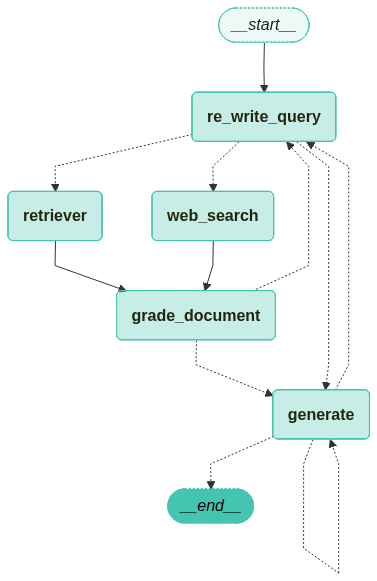

In [9]:
visualize_graph(graph)
# print(graph.get_graph().draw_mermaid())

### 핵심 

1. adaptive agent 라우팅 기법 활용 & BaseModel 과 with_structured_output활용

In [10]:
llm = get_gemini()
structure_rotuer = llm.with_structured_output(RouteQuery)
prompt = get_prompt_routing()
chain = prompt | structure_rotuer 
question = '안녕 친구라는 이름의 영화 검색해줘'
# question = 'AI Brief 에서 삼성전자가 만든 생성형 AI 의 이름은?'
# print(chain.invoke({'question':question}))

2. 관련성 여부 판단하여 문서 filtering 정리



In [11]:
from langchain_core.messages import AIMessage

# Query 생성
query = "삼성전자 AI"
# query = 'AI Brief 에서 삼성전자가 만든 생성형 AI 의 이름은?'
question = [AIMessage(query)]

# retriever 탐색
docs = retriever({'question':question})
# print(docs)
# separators = ["<document>","\n\n", "\n", " ", ""]
# text_splitter=get_text_splitter(separators=separators)

# 수집 문서 docs 변환 

text_splitter=get_text_splitter()
documents = text_splitter.split_text(docs['messages'])

# chain 생성
llm = get_gemini()
structure_rotuer = llm.with_structured_output(GradeDocument)
prompt = get_prompt_grade()
chain = prompt | structure_rotuer 

# grade_document 최종
filtered_docs = []
for doc in documents:
    score = chain.invoke({'question':question,'document':doc})
    if score.datasource =='yes':
        filtered_docs.append(doc)

print(len(filtered_docs))

****************************************************************************************************
retriever
****************************************************************************************************
3


## 실행부

### retriever 사용


[retriever 사용 flow](https://smith.langchain.com/public/3652730b-7b3a-4c62-9e2a-41f883356fe8/r)

In [12]:
# config = get_runnable_config()
# query = '삼성전자 신규 AI'
# inputs= {'question':query}


# # for ev in graph.stream(input=inputs,config=config,interrupt_before='grade_document'):
# #     print(ev)

# invoke_graph(graph, inputs, config)

### 일상 대화

[일상대화 flow](https://smith.langchain.com/public/5aab4319-476b-4c13-8edb-6a3225c66ccf/r)

In [13]:
config = get_runnable_config(thread_id=2)
query = '안녕?'
inputs= {'question':query}


# for ev in graph.stream(input=inputs,config=config,interrupt_before='grade_document'):
#     print(ev)

invoke_graph(graph, inputs, config)

2
****************************************************************************************************
re_write_query
****************************************************************************************************
normal_generate

🔄 Node: re_write_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
안녕하세요, 무엇을 도와드릴까요?
****************************************************************************************************
generate
****************************************************************************************************
****************************************************************************************************
is_hallucination
****************************************************************************************************

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
I am an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. My primary mission is to answ

### 웹 검색
[웹 검색 flow](https://smith.langchain.com/public/34d0ed2d-3034-4ed4-8615-020019e3a716/r)

In [14]:
config = get_runnable_config()
query = '오늘 삼성전자 주식 종가'
inputs= {'question':query}


# for ev in graph.stream(input=inputs,config=config,interrupt_before='grade_document'):
#     print(ev)

invoke_graph(graph, inputs, config)

571c1b4e-95d4-41bc-895c-e3bfa4ca187a
****************************************************************************************************
re_write_query
****************************************************************************************************
web_search

🔄 Node: re_write_query 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
삼성전자 주식의 오늘 종가 정보
****************************************************************************************************
web_search
****************************************************************************************************

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
messages:
<document><content>Samsung Electronics Co Ltd의 오늘 주가는? Samsung Electronics Co Ltd의 오늘 주가는 83,300입니다. Samsung Electronics Co Ltd의 주식 티커는? Samsung Electronics</content><source>https://kr.investing.com/equities/samsung-electronics-co-ltd</source></document>
<document><content>전일종가. 84,700. 시가. 84,200. 고가. 85,500. 저가. 83,700. 시가총액. 5,05

In [15]:
# 최종 출력
# outputs = graph.get_state(config).values
# print(outputs)
# print(f'Original Question: {outputs["question"][0].content}')
# print(f'Rewritten Question: {outputs["question"][-1].content}')
# print("===" * 20)
# print(f'Answer:\n{outputs["answer"]}')